In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision.models import densenet121,inception_v3,densenet201,resnet152,resnet18
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import glob
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()

df = pd.read_csv('train.csv')
df.head()

/home/renat/anaconda3/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,image_id,healthy,multiple_diseases,rust,scab,target,fold
0,Train_0,0,0,0,1,3,3
1,Train_1,0,1,0,0,1,1
2,Train_2,1,0,0,0,0,0
3,Train_3,0,0,1,0,2,1
4,Train_4,1,0,0,0,0,1


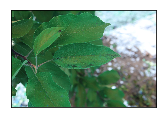

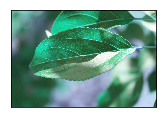

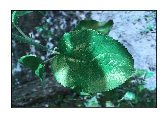

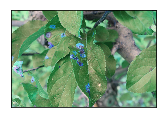

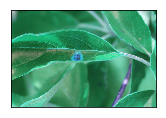

In [2]:
images = glob.glob('images/*.jpg')
for i in range(5):
    image = cv2.imread(images[i])
    plt.figure(figsize=(12,5))
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

2    622
3    592
0    516
1     91
Name: target, dtype: int64


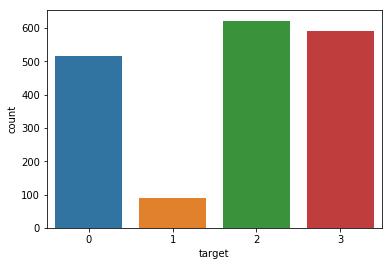

In [3]:
print(df['target'].value_counts())
sns.countplot(df['target'])

In [4]:
class PlantDataset(Dataset):
    def __init__(self, csv, transformer):
        self.data = csv
        self.transform = transformer
        #print(self.data)
        #print(torch.eye(4)[self.data['target']])
        self.labels = torch.eye(4)[self.data['target']]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         #image = Image.open('images/'+self.data.loc[idx]['image_id']+'.jpg')
#         #image = self.transform(image)
#         img = Image.open('images/'+self.data.loc[idx]['image_id']+'.jpg')
        
#         image = self.transform(image =  img)['image']
#         labels = torch.tensor(self.data.loc[idx]['target'])
#         return {'images':image,'labels':labels}
        image_src = 'images/' + self.data.loc[idx, 'image_id'] + '.jpg'
        #print(image_src)
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = torch.tensor(self.data.loc[idx]['target'])
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        #print(image)
        return {'images':image, 'labels':labels}

In [5]:
train_fold = df[df['fold'] != 0]
valid_fold = df[df['fold'] == 0]

In [6]:
train_fold = train_fold.reset_index(drop=True)

In [7]:
#simple_transform = transforms.Compose([transforms.Resize((320,512)),transforms.ToTensor(),transforms.Normalize([0.496,0.456,0.406],[0.229,0.224,0.225])])

In [8]:
import albumentations as A
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F
from albumentations.pytorch import ToTensorV2

/home/renat/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [9]:
simple_transform = A.Compose([
            A.Resize(320,512, p=1.0),
            A.Blur(always_apply=False, p=1.0, blur_limit=(3, 6)),
            A.Flip(always_apply=False, p=1.0),    
            A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.10000000149011612, 0.20000000298023224), contrast_limit=(-0.10000000149011612, 0.20000000298023224), brightness_by_max=True),
            A.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit=(-0.05999999865889549, 0.05999999865889549), scale_limit=(-0.10000000149011612, 0.10000000149011612), rotate_limit=(-30, 30), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
            A.Normalize(
                mean=[0.496, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                p=1.0
            ),
            ToTensorV2(p=1.0),
            ], p=1)

In [10]:
train_dataset = PlantDataset(train_fold,simple_transform)

In [11]:
valid_fold = valid_fold.reset_index(drop=True)

In [12]:
valid_dataset = PlantDataset(valid_fold,simple_transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=16)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [14]:
N_CLASSES = 4

In [15]:
from torch.nn import functional as F
import torchvision.models as M
from functools import partial

In [16]:
class AvgPool(nn.Module):
    def forward(self, x):
        return F.avg_pool2d(x, x.shape[2:])


def create_net(net_cls, pretrained: bool):
    if pretrained:
        net = net_cls()
        model_name = net_cls.__name__
        weights_path = f'{model_name}/{model_name}.pth'
        net.load_state_dict(torch.load(weights_path))
    else:
        net = net_cls(pretrained=pretrained)
    return net


class ResNet(nn.Module):
    def __init__(self, num_classes,
                 pretrained=False, net_cls=M.resnet50, dropout=False):
        super().__init__()
        self.net = create_net(net_cls, pretrained=pretrained)
        self.net.avgpool = AvgPool()
        if dropout:
            self.net.fc = nn.Sequential(
                nn.Dropout(),
                nn.Linear(self.net.fc.in_features, num_classes),
            )
        else:
            self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def fresh_params(self):
        return self.net.fc.parameters()

    def forward(self, x):
        return self.net(x)


class DenseNet(nn.Module):
    def __init__(self, num_classes,
                 pretrained=False, net_cls=M.densenet121):
        super().__init__()
        self.net = create_net(net_cls, pretrained=pretrained)
        self.avg_pool = AvgPool()
        self.net.classifier = nn.Linear(
            self.net.classifier.in_features, num_classes)

    def fresh_params(self):
        return self.net.classifier.parameters()

    def forward(self, x):
        out = self.net.features(x)
        out = F.relu(out, inplace=True)
        out = self.avg_pool(out).view(out.size(0), -1)
        out = self.net.classifier(out)
        return out


resnet18 = partial(ResNet, net_cls=M.resnet18)
resnet34 = partial(ResNet, net_cls=M.resnet34)
resnet50 = partial(ResNet, net_cls=M.resnet50)
resnet101 = partial(ResNet, net_cls=M.resnet101)
resnet152 = partial(ResNet, net_cls=M.resnet152)

densenet121 = partial(DenseNet, net_cls=M.densenet121)
densenet169 = partial(DenseNet, net_cls=M.densenet169)
densenet201 = partial(DenseNet, net_cls=M.densenet201)
densenet161 = partial(DenseNet, net_cls=M.densenet161)

In [17]:
criteria = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [18]:
model = resnet50(num_classes=N_CLASSES, pretrained=True)

In [19]:
from torch import nn, cuda

In [20]:
use_cuda = cuda.is_available()

In [21]:
fresh_params = list(model.fresh_params())
all_params = list(model.parameters())
if use_cuda:
    model = model.cuda()

In [22]:
batch_size = 16

In [23]:
lr = 1e-4

In [24]:
optimizer = optim.Adam(model.parameters(),lr = lr)

In [25]:
from sklearn.metrics import fbeta_score, roc_auc_score

In [26]:
def fit(epochs,model,criteria,optimizer):
    for epoch in range(epochs+1):
        training_loss = 0.0
        validation_loss = 0.0
        correct = 0.0
        total = 0.0
        
        print('{}/{} Epochs'.format(epoch+1,epochs))
        losses = []
        tq = tqdm(total=(len(train_loader) * batch_size))
        #tq = tqdm(total=(len(train_loader)))
        tq.set_description(f'Epoch {epoch}, lr {lr}')
        model.train()
        mean_loss = 0
        for batch_idx,d in enumerate(train_loader):
            data = d['images'].cuda()
            target = d['labels'].cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criteria(output,target)
            loss.backward()
            optimizer.step()
            
            
            pred = output.data.max(1,keepdim = True)[1]
            
            training_loss = training_loss + (1+(batch_idx+1))*(loss.data-training_loss)
            
            tq.update(batch_size)
            losses.append(loss.item())
            mean_loss = np.mean(losses[-20:])
            tq.set_postfix(loss=f'{mean_loss:.3f}')
                
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            
            total += data.size(0)
            accuracy = correct*100/total
            tq.set_postfix(loss=f'{mean_loss:.3f}', accuracy=f'{accuracy}')

        tq.close()    
        model.eval()
        losses_val = []
        val_preds = None
        val_labels = None
        for batch_idx,d in enumerate(valid_loader):
            data = d['images'].cuda()
            target = d['labels'].cuda()
            
            if val_labels is None:
                val_labels = target.clone().squeeze(-1)
            else:
                val_labels = torch.cat((val_labels, target.squeeze(-1)), dim=0)
            with torch.no_grad():
                output = model(data)
                loss = criteria(output,target)
                losses_val.append(loss.item())
                validation_loss = validation_loss + (1/(batch_idx+1))*(loss.data-validation_loss)
                pred = output.data.max(1,keepdim = True)[1]

                preds = torch.nn.functional.softmax(output, 1).cpu()

                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)
                
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
        print('Validation loss of {}'.format(np.mean(losses_val)))      
        print('Validation accuracy of {}'.format(correct*100/total)) 
        print(roc_auc_score(val_labels.cpu(), val_preds.cpu(), multi_class="ovr",average='weighted'))

In [27]:
fit(3, model, criteria, optimizer)

Epoch 0, lr 0.0001:   0%|          | 0/1440 [00:00<?, ?it/s]

1/3 Epochs


Epoch 1, lr 0.0001:   0%|          | 0/1440 [00:00<?, ?it/s]

Validation loss of 0.2754255232214928
Validation accuracy of 86.76551345414607
0.987638188528054
2/3 Epochs


Epoch 2, lr 0.0001:   0%|          | 0/1440 [00:00<?, ?it/s]

Validation loss of 0.21051414221525191
Validation accuracy of 92.20208676551346
0.9900243863709542
3/3 Epochs


Epoch 3, lr 0.0001:   0%|          | 0/1440 [00:00<?, ?it/s]

Validation loss of 0.20588500171899796
Validation accuracy of 94.12410763316859
0.9921874834523656
4/3 Epochs


Epoch 3, lr 0.0001: 100%|██████████| 1440/1440 [00:52<00:00, 27.44it/s, accuracy=94.76987447698745, loss=0.158]


Validation loss of 0.2591505134105682
Validation accuracy of 94.61834157056562
0.9873884379337432


In [28]:
class PredictData(Dataset):
    def __init__(self,csv,transform):
        self.data = csv
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image = Image.open('images/'+self.data.loc[idx]['image_id']+'.jpg')
        image = self.transform(image)
        return {'images':image}

In [29]:
test_df = pd.read_csv('test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [30]:
simple_transform = transforms.Compose([transforms.Resize((320,512)),transforms.ToTensor(),transforms.Normalize([0.496,0.456,0.406],[0.229,0.224,0.225])])

In [31]:
predictionData = PredictData(test_df,simple_transform)

In [32]:
predictloader = DataLoader(predictionData)

In [33]:
predict = []
for batch_idx, d in tqdm(enumerate(predictloader)):
    data = d['images'].cuda()
    
    output = model(data)
    output = output.cpu().detach().numpy()
    #output = np.argmax(output)
    predict.append(output)
    #print(output)

1821it [01:08, 26.75it/s]


In [34]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,-8.516403,7.358088,4.522404,-3.457401
1,Test_1,-6.005470,5.415817,4.001826,-3.390841
2,Test_2,-6.477712,1.290721,-4.874994,9.983238
3,Test_3,4.327228,-2.833398,-0.165867,-1.208278
4,Test_4,-6.121602,4.717188,5.136083,-3.741590


In [35]:
healthy = []
multiple_disease = []
rust = []
scab = []
for i in tqdm(range(len(predict))):
    healthy.append(predict[i][0][0])
    multiple_disease.append(predict[i][0][1])
    rust.append(predict[i][0][2])
    scab.append(predict[i][0][3])

100%|██████████| 1821/1821 [00:00<00:00, 726789.19it/s]


In [36]:
sample_submission['healthy'] = healthy
sample_submission['multiple_diseases'] = multiple_disease
sample_submission['rust'] = rust
sample_submission['scab'] = scab

In [37]:
sample_submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,-2.573895,1.172009,4.039872,-2.727987
1,Test_1,-1.394834,0.658650,3.466685,-2.852457
2,Test_2,-3.672306,-0.835724,-5.954582,9.729254
3,Test_3,5.892762,-3.088472,-0.403377,-1.929361
4,Test_4,-4.856292,0.679219,6.453780,-2.931097


In [38]:
sample_submission.to_csv('sample_submission.csv',index = False)